**Содержание**<a id='toc0_'></a>    
- [Рекомендация тарифов](#toc1_)    
  - [Откройте и изучите файл](#toc1_1_)    
  - [Разбейте данные на выборки](#toc1_2_)    
  - [Исследуйте модели](#toc1_3_)    
  - [Проверьте модель на тестовой выборке](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Рекомендация тарифов](#toc0_)

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

`/datasets/users_behavior.csv`<br>
`calls` — количество звонков,<br>
`minutes` — суммарная длительность звонков в минутах,<br>
`messages` — количество sms-сообщений,<br>
`mb_used` — израсходованный интернет-трафик в Мб,<br>
`is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## <a id='toc1_1_'></a>[Откройте и изучите файл](#toc0_)

In [1]:
import pandas as pd
import itertools
from tqdm import tqdm
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    print('При чтение файла возникал ошибка')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


## <a id='toc1_2_'></a>[Разбейте данные на выборки](#toc0_)

Разобьем данные в пропорции: обучающие 60%, валидационные 20%, тестовые 20%.

In [ ]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

features_tmp, features_test, target_tmp, target_test = train_test_split(
   features, target, test_size=0.20, random_state=2128506, stratify=target)
features_train, features_valid, target_train, target_valid = train_test_split(
   features_tmp, target_tmp, test_size=0.25, random_state=2128506, stratify=target_tmp)

## <a id='toc1_3_'></a>[Исследуйте модели](#toc0_)

**Дерево решений**

In [5]:
dtc_best_model = None
dtc_best_result = 0
dtc_best_depth = 0
dtc_best_leaf = 0
dtc_best_split = 0

for depth in range(1,11):
    for leaf in range(1,11):
        for split in range(2,35):
            dtc_model = DecisionTreeClassifier(
                random_state=2128506, 
                max_depth=depth, 
                min_samples_leaf=leaf, 
                min_samples_split=split
            )
            dtc_model.fit(features_train, target_train) 
            predictions = dtc_model.predict(features_valid)
            result = accuracy_score(target_valid, predictions)
            if result > dtc_best_result:
                dtc_best_model = dtc_model
                dtc_best_result = result
                dtc_best_depth = depth
                dtc_best_leaf = leaf
                dtc_best_split = split
print("Accuracy наилучшей модели 'Дерево решений' на валидационной выборке:", dtc_best_result, 'Параметры.' 'depth:', dtc_best_depth, 'leaf:', dtc_best_leaf, 'split:', dtc_best_split)

Accuracy наилучшей модели 'Дерево решений' на валидационной выборке: 0.80248833592535 Параметры.depth: 5 leaf: 1 split: 2


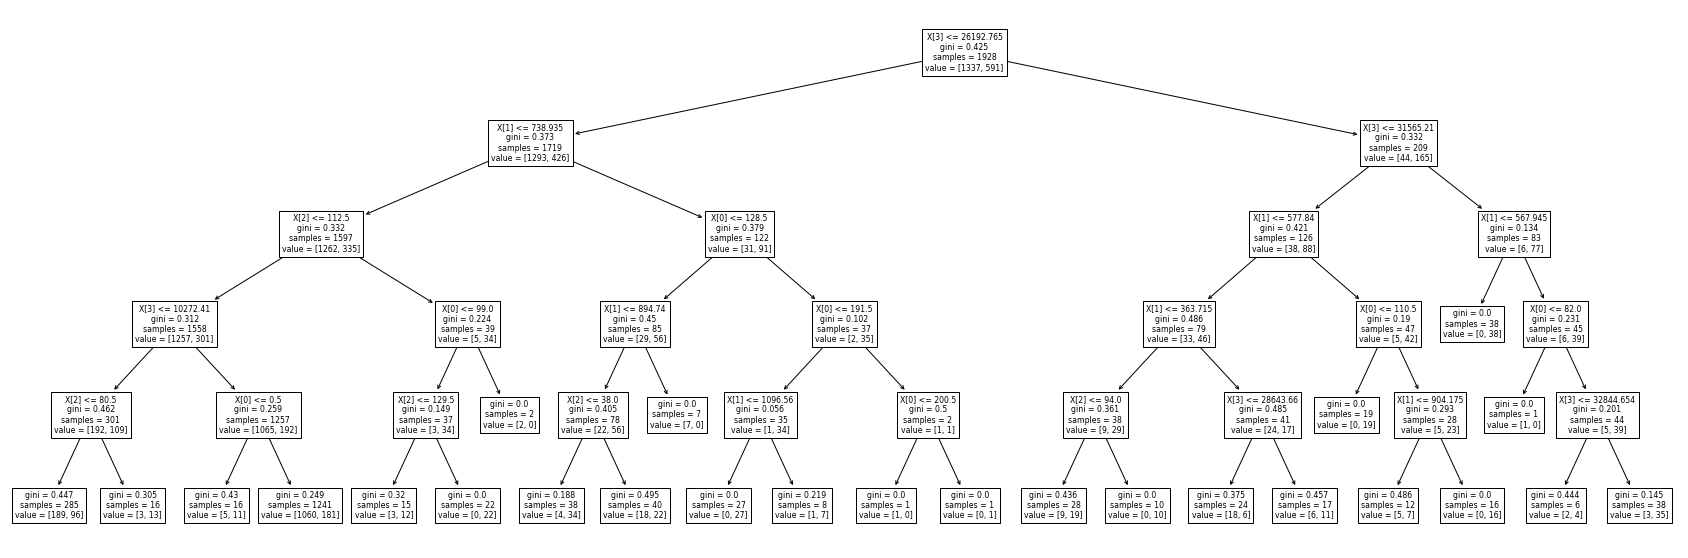

In [6]:
fig, ax = plt.subplots(figsize=(30,10))
tree.plot_tree(dtc_best_model)
plt.show()

Такие диапозны проверки указаны, чтобы уменьшеть время выполнения кода. Изначально были проверены параметры до 50, но точности это не прибавило, а время выполнения было долгим.

**Случайный лес**

In [7]:
rfc_best_model = None
rfc_best_params = None
rfc_best_result = 0

for params in tqdm(itertools.product(range(1,6),range(1,9),range(2,3), range(1,8))):
    depth, est, min_s_s, min_s_l = params
    rfc_model = RandomForestClassifier(
        random_state=2128506, 
        max_depth=depth,
        n_estimators=est,
        min_samples_split=min_s_s, 
        min_samples_leaf=min_s_l
    )
    rfc_model.fit(features_train, target_train)
    predictions = rfc_model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    if result > rfc_best_result:
        rfc_best_model = rfc_model
        rfc_best_result = result
        rfc_best_params = params
print(f'Accuracy наилучшей модели "Случайный лес": {np.round(rfc_best_result,5)}')
print(f'\nПараметры:\nmax_depth = {rfc_best_params[0]}\nn_estimators = {rfc_best_params[1]}\nmin_samples_split={rfc_best_params[2]}\nmin_samples_leaf = {rfc_best_params[3]}')

280it [00:03, 86.54it/s] 

Accuracy наилучшей модели "Случайный лес": 0.81337

Параметры:
max_depth = 5
n_estimators = 8
min_samples_split=2
min_samples_leaf = 7


**Логистическая регрессия**

In [ ]:
lr_best_model = None
lr_best_result = 0

# словарь для перебора параметров
params = {'newton-cg' : ['l2','none'], 'lbfgs': ['l2','none'], 'sag': ['l2','none'], 'saga': ['elasticnet', 'l1', 'l2', 'none'], 'liblinear': ['l1','l2']}

# нормализация данных
features = df.drop('is_ultra', axis=1)
names = features.columns
norm = preprocessing.normalize(features,axis=0)
features = pd.DataFrame(norm, columns=names)

target = df['is_ultra']

features_tmp, features_test, target_tmp, target_test = train_test_split(
   features, target, test_size=0.20, random_state=2128506, stratify=target)
features_train, features_valid, target_train, target_valid = train_test_split(
   features_tmp, target_tmp, test_size=0.25, random_state=2128506, stratify=target_tmp)

for slvr in params:
    for pnlt in params[slvr]:
        l1_rt=None
        if pnlt == 'elasticnet':
            l1_rt = 0.5
        lr_model = LogisticRegression(random_state=2128506, solver=slvr, penalty=pnlt, l1_ratio=l1_rt, max_iter=300)
        lr_model.fit(features_train, target_train)
        predictions = lr_model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        if result > lr_best_result:
            lr_best_model = lr_model
            lr_best_result = result
            lr_best_pnlt = pnlt
            lr_best_slvr = slvr   
print(f'Accuracy наилучшей модели "Случайный лес": {np.round(lr_best_result,5)}')
print(f'\nПараметры:\nsolver = {lr_best_slvr}\npenalty = {lr_best_pnlt}')

Accuracy наилучшей модели "Случайный лес": 0.75739

Параметры:
solver = lbfgs
penalty = none


## <a id='toc1_4_'></a>[Проверьте модель на тестовой выборке](#toc0_)

**Дерево решений**

In [15]:
predictions = dtc_best_model.predict(features_test)
dtc_result_test = accuracy_score(target_test, predictions)
print('Score:', dtc_result_test, 'Выборка для обучения - только обучающая')

dtc_model.fit(features_tmp, target_tmp) 
# predictions = dtc_best_model.predict(features_test)
predictions = dtc_model.predict(features_test)
dtc_result_test = accuracy_score(target_test, predictions)
print('Score:', dtc_result_test, 'Выборка для обучения - обучающая+валидационная')

Score: 0.6936236391912908 Выборка для обучения - только обучающая
Score: 0.7744945567651633 Выборка для обучения - обучающая+валидационная


<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Когда гиперпараметры подобраны и валидационная выборка нам уже не нужна, мы можем обучить модель на бОльшей выборке (обучающая + валидационная), это позволит улучшить результаты на тестовой выборке


**Случайный лес**

In [10]:
predictions = rfc_best_model.predict(features_test)
rfc_result_test = accuracy_score(target_test, predictions)
print('Score:', rfc_result_test, 'Выборка для обучения - только обучающая')

rfc_best_model.fit(features_tmp, target_tmp) 
predictions = rfc_best_model.predict(features_test)
rfc_result_test = accuracy_score(target_test, predictions)
print('Score:', rfc_result_test, 'Выборка для обучения - обучающая+валидационная')

Score: 0.30637636080870917 Выборка для обучения - только обучающая
Score: 0.80248833592535 Выборка для обучения - обучающая+валидационная


**Логистическая регрессия**

Без нормализации

In [11]:
predictions = lr_best_model.predict(features_test)
lr_result_test = accuracy_score(target_test, predictions)
print('Score:', lr_result_test, 'Выборка для обучения - только обучающая')

lr_best_model.fit(features_tmp, target_tmp)
predictions = lr_best_model.predict(features_test)
lr_result_test = accuracy_score(target_test, predictions)
print('Score:', lr_result_test, 'Выборка для обучения - обучающая_валидационная')

Score: 0.749611197511664 Выборка для обучения - только обучающая
Score: 0.7511664074650077 Выборка для обучения - обучающая_валидационная


С нормализванными данными

In [12]:
names = features_tmp.columns
norm = preprocessing.normalize(features_tmp,axis=0)
features_tmp = pd.DataFrame(norm, columns=names)

lr_best_model.fit(features_tmp, target_tmp)
predictions = lr_best_model.predict(features_test)
lr_result_test = accuracy_score(target_test, predictions)
print('Score:', lr_result_test, 'Выборка для обучения - обучающая+валидационная')

Score: 0.7356143079315708 Выборка для обучения - обучающая+валидационная


**Вывод**

In [13]:
columns = ['model', 'validation', 'test']
rows = [['DecisionTreeClassifier', dtc_best_result, dtc_result_test], ['RandomForestClassifier', rfc_best_result, rfc_result_test], ['LogisticRegression', lr_best_result, lr_result_test ]]
df_compare = pd.DataFrame(data=rows, columns=columns)

In [14]:
df_compare['diff'] = df_compare['validation'] - df_compare['test']
df_compare

,model,validation,test,diff
0,DecisionTreeClassifier,0.802488,0.693624,0.108865
1,RandomForestClassifier,0.813375,0.802488,0.010886
2,LogisticRegression,0.757387,0.735614,0.021773


Модель логистической регрессия выглядит как недообученная с низким значением точности. <br>
Модели случайного леса и дерева решений имеют очень схожие результаты. Принимая во внимание, что разница точности на валидационных и тестовых выборках у модели "случайный лес" меньше, чем у "дерева решений", модель случайного дерева выглядит предпочтительнее, т.к. имеет самую большую точность.
